In [26]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from sleeprnn.data import utils
from sleeprnn.common import viz

viz.notebook_full_width()

In [85]:
# obtained through first order taylor expansion equality between gaussian and hann windows
sigma_truncation = np.sqrt(2) * np.pi / 2
print(sigma_truncation)

2.221441469079183


# Cycles in gaussian window similar to hann window

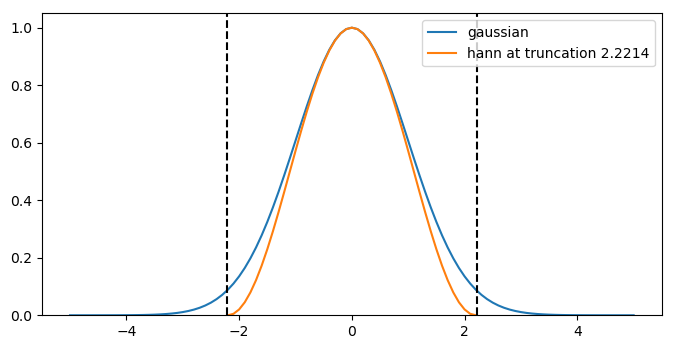

In [84]:
fs = 10
max_t = 5
sigma_truncation = 2.2214  # obtained through first order taylor expansion equality between gaussian and hann windows
t = np.arange(-max_t*fs, max_t*fs + 0.001) / fs
window_gauss = np.exp(-(t ** 2) / 2)
effective_size = 2 * (np.sum(np.abs(t) <= sigma_truncation) // 2) + 1
window_hann = np.hanning(effective_size)
t_hann = np.arange(effective_size) / fs
t_hann = t_hann - t_hann.mean()

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ax.plot(t, window_gauss, label="gaussian")
ax.plot(t_hann, window_hann, label="hann at truncation %s" % sigma_truncation)
ax.axvline(-sigma_truncation, color="k", linestyle="--")
ax.axvline(sigma_truncation, color="k", linestyle="--")
ax.legend()
ax.set_ylim([0, None])
plt.show()

# CMorlet wavelet with expansion factor

In [70]:
def adjust_scale(scale, q, max_scale):
    return scale * q + max_scale * (1.0 - q)


def beta_for_cycles_at_frequency(n_cycles, frec, q, min_freq, sigma_truncation=3):
    scale = 1 / frec
    adjusted_scale = adjust_scale(scale, q, 1/min_freq)
    adjustment_term = (adjusted_scale / scale) ** 2
    truncation_term = 2 * (sigma_truncation ** 2)
    beta = (n_cycles ** 2 / truncation_term) / adjustment_term
    return beta


def generate_wavelets(
    min_freq,
    max_freq,
    n_scales,
    beta,
    q=1.0,
    fs=200,
    size_factor=1.0,
):
    s_0 = 1.0 / max_freq
    s_n = 1.0 / min_freq
    base = np.power(s_n / s_0, 1.0 / (n_scales - 1.0))
    scales = s_0 * np.power(base, np.arange(n_scales))
    scales = scales.astype(np.float32)
    scales = np.flip(scales) # So that frequencies are in increasing order
    adjusted_scales = adjust_scale(scales, q, s_n)
    # Frequencies
    frequencies = 1 / scales
    # Time axis
    one_side = int(size_factor * np.max(adjusted_scales) * fs * np.sqrt(4.5 * beta))
    kernel_size = 2 * one_side + 1
    k_array = np.arange(kernel_size, dtype=np.float32) - one_side
    k_array = k_array / fs  # Time units
    # Wavelet bank shape: 1, kernel_size, 1, n_scales
    wavelet_bank_real = []
    wavelet_bank_imag = []
    for i in range(n_scales):
        norm_constant = np.sqrt(np.pi * beta) * adjusted_scales[i] * fs / 2.0
        exp_term = np.exp(-((k_array / adjusted_scales[i]) ** 2) / beta)
        kernel_window = exp_term / norm_constant
        kernel_real = kernel_window * np.cos(2 * np.pi * k_array / scales[i])
        kernel_imag = kernel_window * np.sin(2 * np.pi * k_array / scales[i])
        wavelet_bank_real.append(kernel_real)
        wavelet_bank_imag.append(kernel_imag)
    # Stack wavelets (shape = kernel_size, n_scales)
    wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
    wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)
    return wavelet_bank_real, wavelet_bank_imag, frequencies

In [131]:
min_freq = 0.5
q = 0.9
frec = 13
sigma_truncation_for_cycles = 2.2214
print("Expansion factor %1.2f, min freq %s Hz, and truncating at %s sigmas of gaussian window to count cycles" % (q, min_freq, sigma_truncation_for_cycles))
for n_cycles in [2, 3, 4, 5, 6, 7]:
    beta = beta_for_cycles_at_frequency(n_cycles, frec, q, min_freq, sigma_truncation=sigma_truncation_for_cycles)
    print("Use beta %1.4f to have %s cycles at %s Hz" % (beta, n_cycles, frec))

Expansion factor 0.90, min freq 0.5 Hz, and truncating at 2.2214 sigmas of gaussian window to count cycles
Use beta 0.0331 to have 2 cycles at 13 Hz
Use beta 0.0744 to have 3 cycles at 13 Hz
Use beta 0.1323 to have 4 cycles at 13 Hz
Use beta 0.2068 to have 5 cycles at 13 Hz
Use beta 0.2978 to have 6 cycles at 13 Hz
Use beta 0.4053 to have 7 cycles at 13 Hz


Beta 0.0331
Kernel size 309
Kernel size 309
Kernel size 309


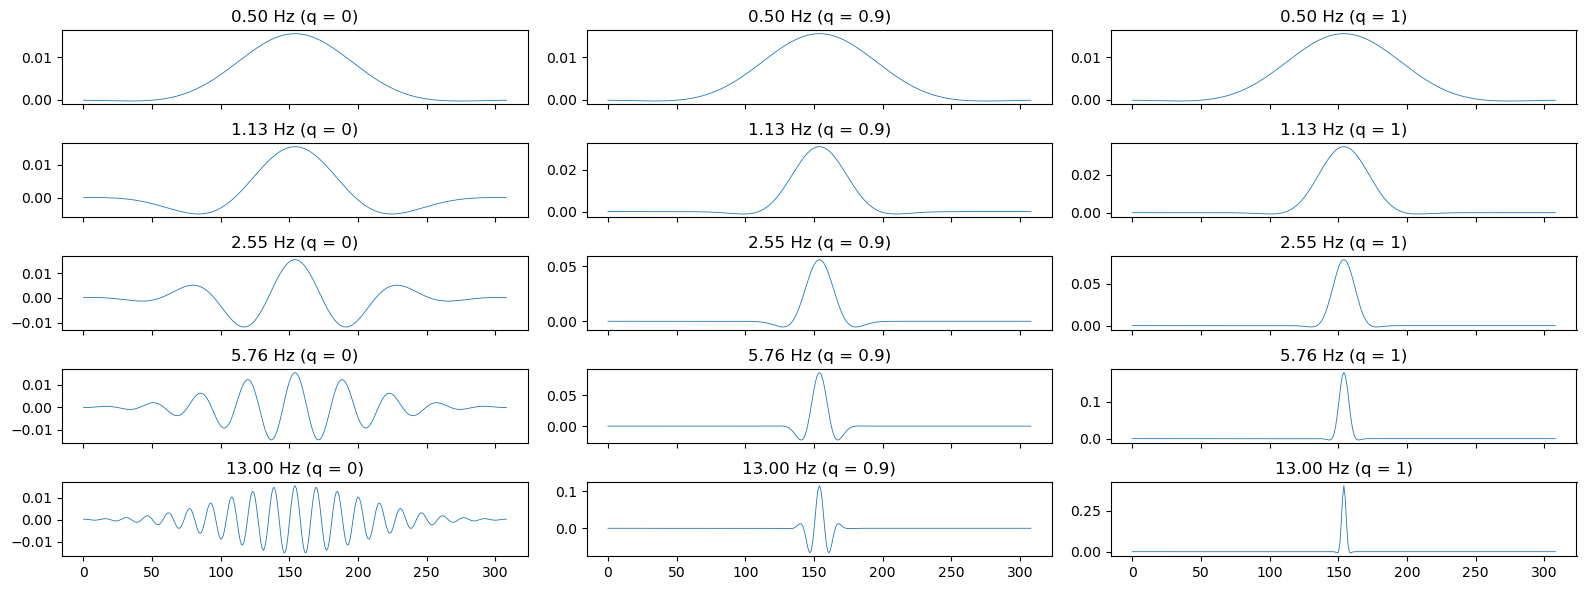

In [132]:
beta = 0.0331
n_scales = 5
min_freq = 0.5
max_freq = 13
q_list = [0, 0.9, 1]

print("Beta %s" % beta)
fig, ax = plt.subplots(n_scales, len(q_list), sharex=True, dpi=100, figsize=(16, 6))
for i, q in enumerate(q_list):
    w_real, w_imag, freqs = generate_wavelets(min_freq, max_freq, n_scales, beta, q)
    print("Kernel size", w_real.shape[0])
    for j in range(n_scales):
        ax[j, i].plot(w_real[:, j], linewidth=0.6)
        # ax[j, i].plot(w_imag[:, j], linewidth=0.6)
        ax[j, i].set_title("%1.2f Hz (q = %s)" % (freqs[j], q))
plt.tight_layout()
plt.show()


# Original wavelet

In [ ]:
fs = 200
upper_freq = 13
lower_freq = 2
n_scales = 4
size_factor = 1.0
beta = 0.5

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
one_side = size_factor * int(scales[-1] * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    norm_constant = np.sqrt(np.pi * beta) * scale * fs / 2.0
    exp_term = np.exp(-((k_array / scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz" % frequencies[i], loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

# Wavelet with expansion factor

In [ ]:
fs = 200
upper_freq = 13
lower_freq = 0.5
n_scales = 4
size_factor = 1.0
beta = 0.1201

logit_expansion_factor = 1.39  # 1.39 -> 0.8; 2.2 -> 0.9
expansion_factor = 1 / (1 + np.exp(-logit_expansion_factor))

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
largest_scale = scales[-1]
largest_scale_expanded = expansion_factor * largest_scale + (1 - expansion_factor)
one_side = size_factor * int(largest_scale_expanded * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
print("kernel size", kernel_size)
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    expanded_scale = expansion_factor * scale + (1 - expansion_factor)
    norm_constant = np.sqrt(np.pi * beta) * expanded_scale * fs / 2.0
    exp_term = np.exp(-((k_array / expanded_scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz (expansion %1.4f)" % (frequencies[i], expansion_factor), loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

In [ ]:
fs = 200
upper_freq = 13
lower_freq = 0.5
n_scales = 4
size_factor = 1.0
beta = 0.287

logit_expansion_factor = 2.2  # 1.39 -> 0.8; 2.2 -> 0.9
expansion_factor = 1 / (1 + np.exp(-logit_expansion_factor))

# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
# Generate the frequency range
frequencies = 1 / scales
largest_scale = scales[-1]
largest_scale_expanded = expansion_factor * largest_scale + (1 - expansion_factor)
one_side = size_factor * int(largest_scale_expanded * fs * np.sqrt(4.5 * beta))
kernel_size = 2 * one_side + 1
print("kernel size", kernel_size)
k_array = np.arange(kernel_size, dtype=np.float32) - one_side
k_array = k_array / fs  # Time units
# Wavelet bank shape: 1, kernel_size, 1, n_scales
wavelet_bank_real = []
wavelet_bank_imag = []
for i in range(n_scales):
    scale = scales[i]
    expanded_scale = expansion_factor * scale + (1 - expansion_factor)
    norm_constant = np.sqrt(np.pi * beta) * expanded_scale * fs / 2.0
    exp_term = np.exp(-((k_array / expanded_scale) ** 2) / beta)
    kernel_base = exp_term / norm_constant
    kernel_real = kernel_base * np.cos(2 * np.pi * k_array / scale)
    kernel_imag = kernel_base * np.sin(2 * np.pi * k_array / scale)
    wavelet_bank_real.append(kernel_real)
    wavelet_bank_imag.append(kernel_imag)
# Stack wavelets (shape = kernel_size, n_scales)
wavelet_bank_real = np.stack(wavelet_bank_real, axis=-1)
wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=-1)

fig, ax = plt.subplots(n_scales, 2, figsize=(8, 6), dpi=100)
for i in range(n_scales):
    ax[i, 0].set_title("%1.1f Hz (expansion %1.4f)" % (frequencies[i], expansion_factor), loc="left")
    ax[i, 0].plot(wavelet_bank_real[:, i], linewidth=1)
    ax[i, 0].plot(wavelet_bank_imag[:, i], linewidth=1)
    resp_freq, resp_amp = utils.fir_freq_response(wavelet_bank_real[:, i], fs)
    ax[i, 1].plot(resp_freq, resp_amp, linewidth=1)
    ax[i, 1].set_xlim([0, 30])
    ax[i, 1].axvline(frequencies[i], color="k", linestyle="--")
plt.tight_layout()
plt.show()

In [ ]:
def beta_from_cycles(n, q, frec):
    s = 1 / frec
    main_term = n ** 2 / 18
    q_adjust = (s / (s * q +1 - q)) ** 2
    return main_term * q_adjust

In [ ]:
beta = beta_from_cycles(n=5, q=0.9, frec=13)
print("Beta %1.4f" % beta)

In [ ]:
def logit_from_proba(p):
    l = np.log(p / (1 - p))
    return l

In [ ]:
logit_from_proba(0.98)

In [ ]:
5/15

In [ ]:
def cycles_from_beta(beta, q, frec):
    s = 1 / frec
    s_expanded = s * q + (1 - q)
    cycles = 2 * s_expanded * np.sqrt(4.5 * beta) * frec
    return cycles

In [ ]:
cycles_from_beta(0.2870, 0.9, 3)